In [106]:
import pandas as pd
from lang_pref.config.paths import DATA_PATH

colcon = pd.read_csv(DATA_PATH / 'college_confidential/dataset.csv')
compsent = pd.read_csv(DATA_PATH / 'compsent/dataset.csv')

In [107]:
from pathlib import Path
import json
# Long results

# llama2 70b colcon 

colcon_results = pd.concat([
    pd.DataFrame([
        json.load(open(f))
        for f in Path(
            'output/llm/upstage-llama2-70b-4bit/college_confidential/inwon/without_example'
        ).glob('*.json')
    ]).assign(
        setting = 'long_llama_colcon_zero'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            'output/llm/upstage-llama2-70b-4bit/college_confidential/inwon/with_example'
        ).glob('*.json')
    ]).assign(
        setting = 'long_llama_colcon_few'
    ),
    pd.DataFrame([
        json.load(open(f))
        for f in Path(
            'output/llm/gpt-4/college_confidential/inwon/without_example'
        ).glob('*.json')
    ]).assign(
        setting = 'long_gpt_colcon_zero'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            'output/llm/gpt-4/college_confidential/inwon/with_example'
        ).glob('*.json')
    ]).assign(
        setting = 'long_gpt_colcon_few'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            '/Users/inwon/Downloads/llm-preference/output/llama2-70b/college_confidential_clean_equal=no/sikai2/without_example_textgen'
        ).glob('*.json')
    ]).assign(
        setting = 'short_llama_colcon_zero'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            '/Users/inwon/Downloads/llm-preference/output/llama2-70b/college_confidential_clean_equal=no/sikai2/with_example_textgen'
        ).glob('*.json')
    ]).assign(
        setting = 'short_llama_colcon_few'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            '/Users/inwon/Downloads/llm-preference/output/openai/college_confidential_clean/sikai2/without_example_openai/'
        ).glob('*.json')
    ]).assign(
        setting = 'short_gpt_colcon_zero'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            '/Users/inwon/Downloads/llm-preference/output/openai/college_confidential_clean/sikai2/with_example_openai/'
        ).glob('*.json')
    ]).assign(
        setting = 'short_gpt_colcon_few'
    ), 
])
compsent_results = pd.concat([
    pd.DataFrame([
        json.load(open(f))
        for f in Path(
            'output/llm/upstage-llama2-70b-4bit/compsent/inwon/without_example'
        ).glob('*.json')
    ]).assign(
        setting = 'long_llama_compsent_zero'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            'output/llm/upstage-llama2-70b-4bit/compsent/inwon/with_example'
        ).glob('*.json')
    ]).assign(
        setting = 'long_llama_compsent_few'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            'output/llm/gpt-4/compsent/inwon/without_example'
        ).glob('*.json')
    ]).assign(
        setting = 'long_gpt_compsent_zero'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            'output/llm/gpt-4/compsent/inwon/with_example'
        ).glob('*.json')
    ]).assign(
        setting = 'long_gpt_compsent_few'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            '/Users/inwon/Downloads/llm-preference/output/llama2-70b/compsent/sikai2/without_example_textgen/'
        ).glob('*.json')
    ]).assign(
        setting = 'short_llama_compsent_zero'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            '/Users/inwon/Downloads/llm-preference/output/llama2-70b/compsent/sikai2/with_example_textgen/'
        ).glob('*.json')
    ]).assign(
        setting = 'short_llama_compsent_few'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            '/Users/inwon/Downloads/llm-preference/output/openai/compsent/sikai2/without_example_openai/'
        ).glob('*.json')
    ]).assign(
        setting = 'short_gpt_compsent_zero'
    ), pd.DataFrame([
        json.load(open(f))
        for f in Path(
            '/Users/inwon/Downloads/llm-preference/output/openai/compsent/sikai2/without_example_openai/'
        ).glob('*.json')
    ]).assign(
        setting = 'short_gpt_compsent_few'
    ),
])

In [108]:
(
    sum(colcon_results['setting'] == 'long_llama_colcon_few'),
    sum(colcon_results['setting'] == 'long_llama_colcon_zero'),
    sum(colcon_results['setting'] == 'short_llama_colcon_zero'),
    sum(colcon_results['setting'] == 'short_llama_colcon_few'),
)

(2960, 2964, 2964, 2964)

In [109]:
def count_tokens(text):
    return len(text.split())

In [110]:
colcon_results['token_length'] = colcon_results['index'].map(
    dict(zip(colcon.index, colcon['text'].apply(count_tokens).values))
)

compsent_results['token_length'] = compsent_results['index'].map(
    dict(zip(compsent.index, compsent['text'].apply(count_tokens).values))
)

In [111]:
colcon_results['predicted_label'].replace({3:0},inplace=True)
colcon_results['true_label'].replace({3:0},inplace=True)

In [112]:
bin_range = 200
colcon_results['token_length_bin'] = pd.cut(
    colcon_results['token_length'],
    [
        i*bin_range 
        for i in range(colcon_results['token_length'].max() // bin_range + 2)
    ],
    labels = [
        (i+1) * bin_range
        for i in range(colcon_results['token_length'].max() // bin_range + 1)
    ]
)

In [113]:
error_rates = []
for setting, by_setting in colcon_results.groupby('setting'):
    for token_count, by_token_count in by_setting.groupby('token_length_bin'):
        correct_count = (by_token_count['true_label'] == by_token_count['predicted_label']).sum()
        incorrect_count = by_token_count.shape[0] - correct_count
        prompt_type = ('Long' if 'long' in setting else 'Short')
        model_name = ('GPT-4' if 'gpt' in setting else 'LLaMa-2-70B')
        train_type = ('Zero Shot' if 'zero' in setting else 'Few Shot')

        error_rates += [{
            'Prompt Type': prompt_type + ' ' + train_type,
            'Model Name': model_name,
            'Word Count': token_count,
            'Error Rate': incorrect_count / by_token_count.shape[0],
            'Row Count': by_token_count.shape[0]
        }]
        
error_rates = pd.DataFrame(error_rates)

/var/folders/7c/njhnznd516q7rp062p21kv500000gn/T/ipykernel_95730/2512700772.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for token_count, by_token_count in by_setting.groupby('token_length_bin'):


/Users/inwon/miniconda3/envs/llm-preference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inwon/miniconda3/envs/llm-preference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inwon/miniconda3/envs/llm-preference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Word Count', ylabel='Row Count'>

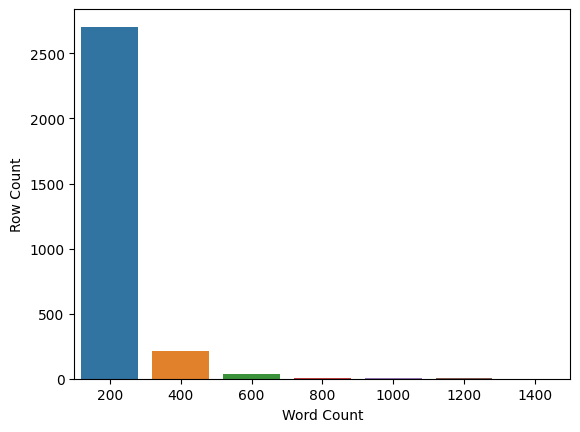

In [114]:
sns.barplot(
    data = error_rates,
    x = 'Word Count',
    y = 'Row Count'
)

/Users/inwon/miniconda3/envs/llm-preference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inwon/miniconda3/envs/llm-preference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inwon/miniconda3/envs/llm-preference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/inwon/miniconda3/envs/llm-preference/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

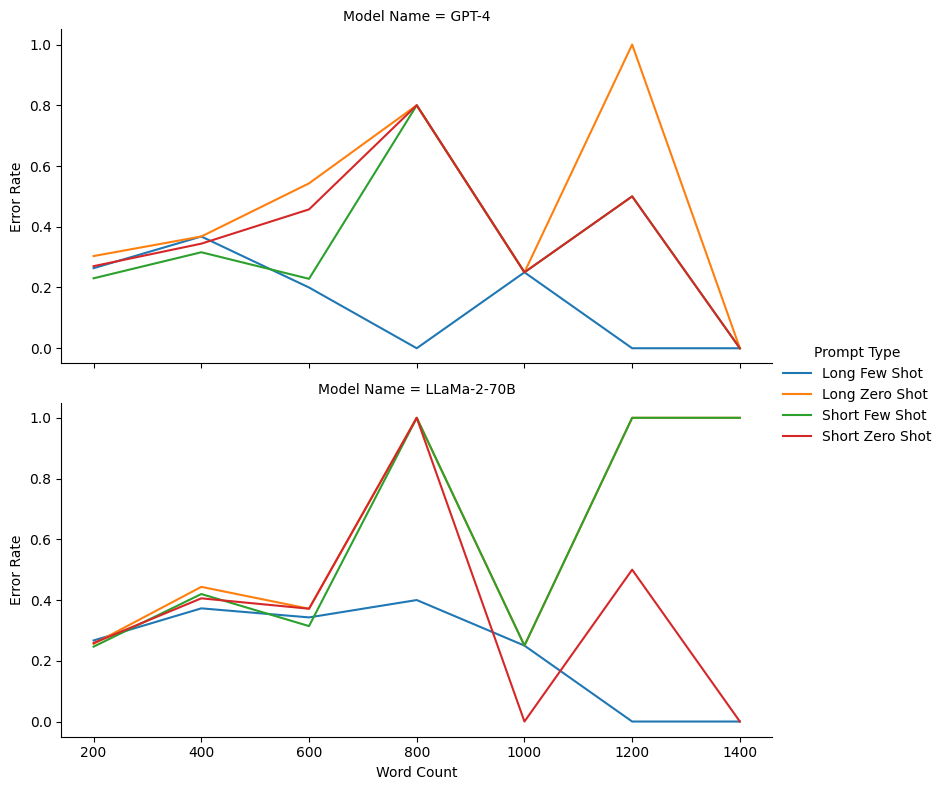

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# fig, axes = plt.subplots(nrows = 2, sharex = True, figsize = (12,6))

# seaborn

sns.relplot(
    data = error_rates,
    x = 'Word Count',
    y = 'Error Rate',
    kind = 'line',
    row = 'Model Name',
    hue = 'Prompt Type',
    aspect = 2,
    height = 4,

)